# WMT of tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

# 1) Make histogram of each term <a class='anchor' id='first-bullet'> </a>

In [7]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram
import pop_tools
import xesmf as xe

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [5]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 14965, nlat: 2400, nlon: 3600)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [6]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [8]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.fe721befd8924c3ea22a60e518b1ae0f/status,


In [57]:
client.close()
cluster.close()

# Split the tendencies by basin

## Regrid coarser mask to finer resolution tendency dataset

In [9]:
grid_name = 'POP_gx1v7'

grid = pop_tools.get_grid(grid_name)
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')

In [56]:
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [25]:
#rename coords to latitude/longitude for regridder to work
mask_coords = mask3d.assign_coords({'latitude':mask3d.nlat, 
                                    'longitude':mask3d.nlon}).swap_dims({'nlat':'latitude', 
                                                                         'nlon':'longitude'})
tend_coords = tendencies.assign_coords({'latitude':tendencies.nlat, 
                                        'longitude':tendencies.nlon}).swap_dims({'nlat':'latitude', 
                                                                                 'nlon':'longitude'})

In [41]:
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

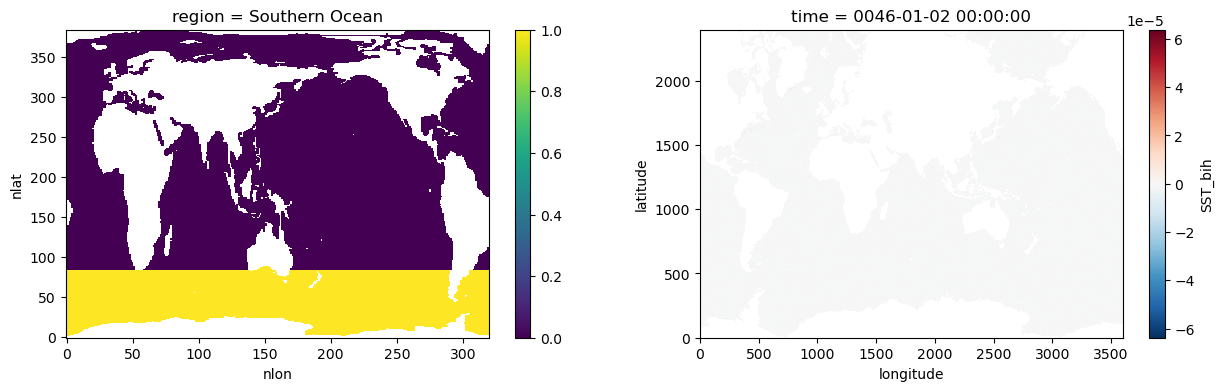

In [45]:
#datasets' lat/lon both increase monotonically but dont start with same lower-left pt spatially 
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15, 4))

mask3d.where(grid.KMT > 0).sel(region='Southern Ocean').plot(ax=ax0)
tend_coords.SST_bih[0].plot(ax=ax1);

In [49]:
grid_obj, ds_ren = pop_tools.to_xgcm_grid_dataset(grid, periodic=False)

In [52]:
ds_ren.REGION_MASK

<xarray.DataArray 'REGION_MASK' (nlat_t: 384, nlon_t: 320)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 316.5 317.5 318.5 319.5
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 380.5 381.5 382.5 383.5
Attributes:
    long_name:    basin index number (signed integers)
    coordinates:  TLONG TLAT
    grid_loc:     2110

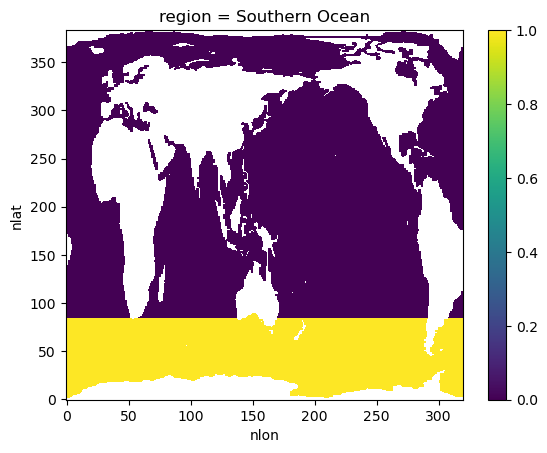

In [47]:
mask3d.where(grid.KMT > 0).sel(region='Southern Ocean').plot()

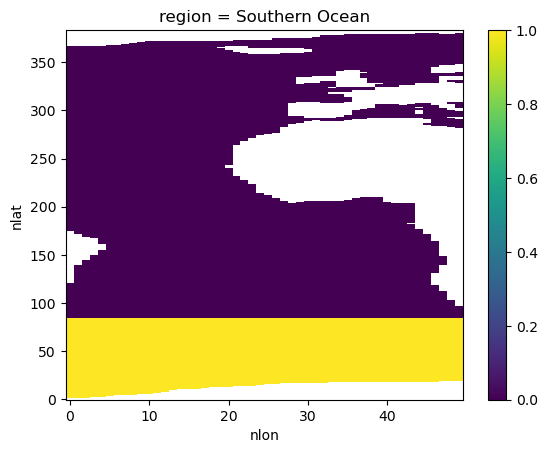

In [48]:
mask3d.where(grid.KMT > 0).sel(region='Southern Ocean').isel(nlon=slice(0,50)).plot()

In [34]:
mask_coords.longitude

<xarray.DataArray 'longitude' (longitude: 320)>
array([  0,   1,   2, ..., 317, 318, 319])
Coordinates:
  * longitude  (longitude) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319

In [33]:
tend_coords.longitude

<xarray.DataArray 'longitude' (longitude: 3600)>
array([   0,    1,    2, ..., 3597, 3598, 3599])
Coordinates:
    nlon       (longitude) int64 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599
  * longitude  (longitude) int64 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599

In [12]:
mask3d.shape

(13, 384, 320)

In [15]:
tendencies.SST_bih.shape

(14965, 2400, 3600)

In [32]:
regridder = xe.Regridder(mask_coords, tend_coords.SST_bih, method='bilinear')

mask_new_grid = regridder(mask_coords)
mask_new_grid

/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


ValueError: The truth value of a Array is ambiguous. Use a.any() or a.all().

## Compute histogram by basin

In [17]:
rho = fastjmd95.rho(ds.SSS, ds.SST, 0)
#rho = rho_unsliced.isel(time=slice(0,182))

In [18]:
area = ds.TAREA * ds.dz * 1e-4 #convert cm^2 to m^2
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [19]:
tendency_terms = xr.merge([(tendencies.SST_bih*tendencies.drhodt).rename('sst'), 
                           (tendencies.SSS_bih*tendencies.drhods).rename('sss'), 
                            tendencies.rho_bih.rename('rho'), 
                            tendencies.cabbeling.rename('cabbeling')])

In [20]:
all_tendencies = list(tendency_terms)

In [21]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(variable.fillna(0.)*ds.TAREA), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [22]:
histograms = xr.merge([histogram_func(tendency_terms[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])

In [29]:
histograms

<xarray.Dataset>
Dimensions:          (time: 14965, rho0_bin: 1499)
Coordinates:
  * time             (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_rho        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>

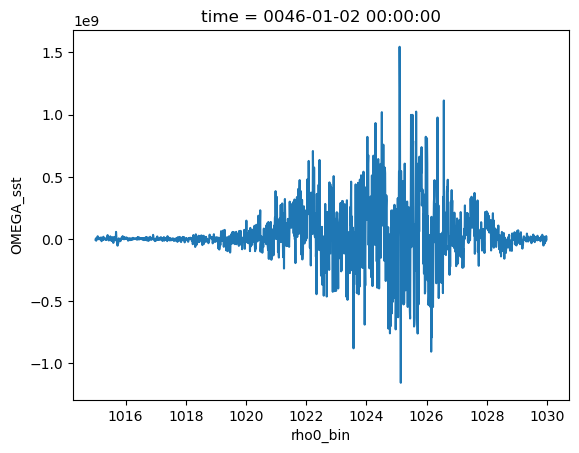

In [24]:
histograms.OMEGA_sst[0].plot()

In [28]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1ac3d59b1bda4c7897fd3a5fd58cefcc/status,


# 2) Save histograms <a class='anchor' id='second-bullet'> </a>

In [ ]:
#saving monthly climatology histograms
gcsmap_hist = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/histograms.zarr')
histograms.to_zarr(gcsmap_hist, mode='w')

Task exception was never retrieved
future: <Task finished name='Task-825' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-826' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-827' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3

[Back to top](#top)